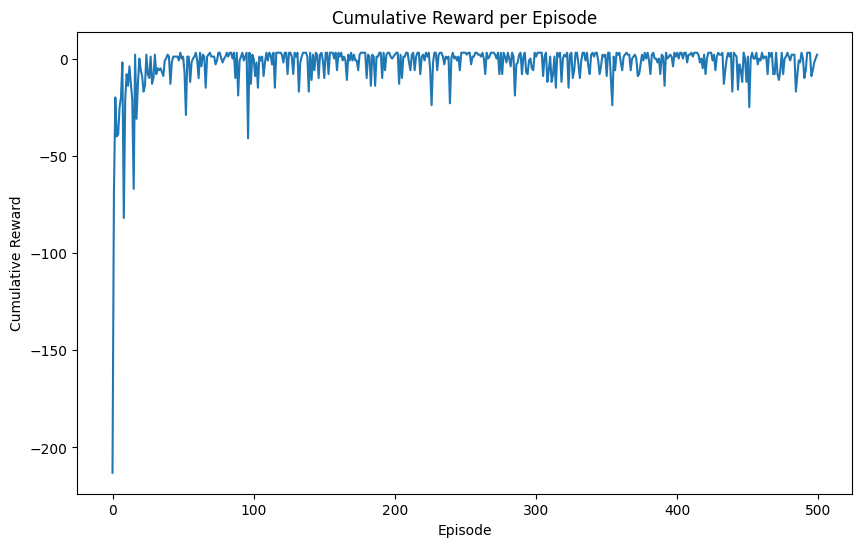

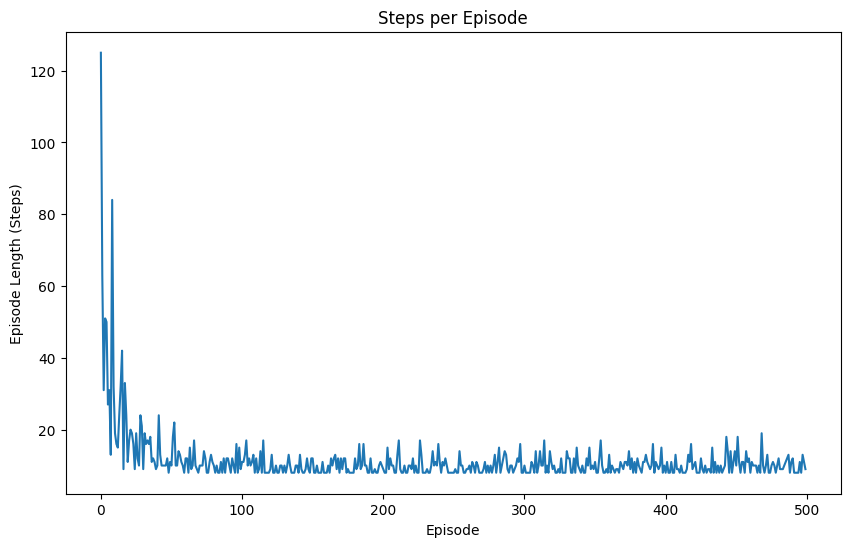

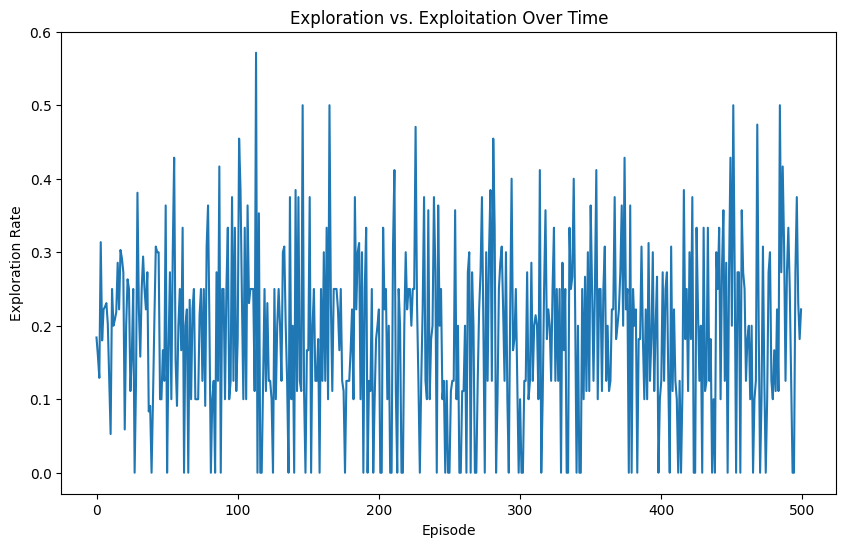

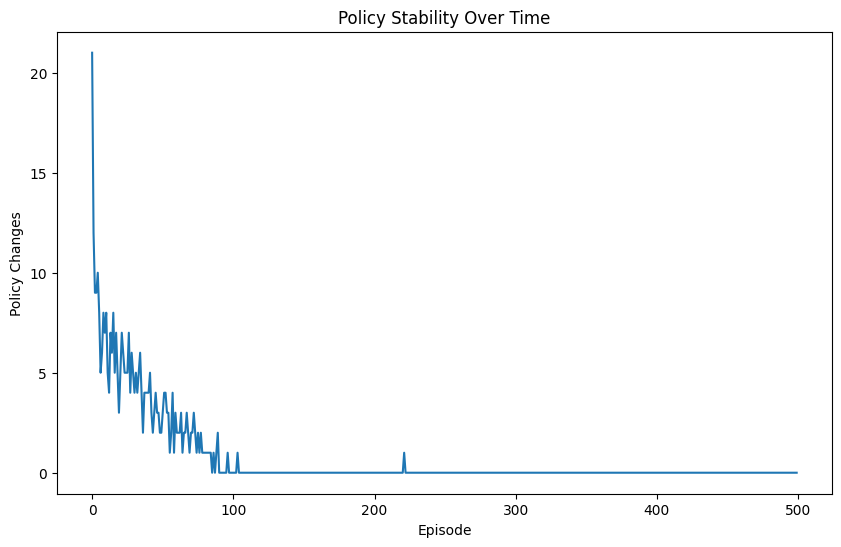

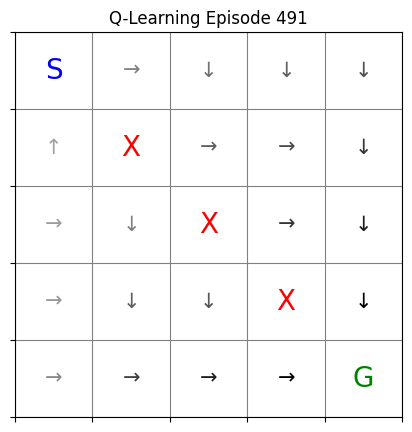

In [4]:
# Import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Set up environment parameters
grid_size = 5
start = (0, 0)
goal = (4, 4)
obstacles = [(1, 1), (2, 2), (3, 3)]  # Optional obstacles

# Actions (Up, Down, Left, Right)
actions = {
    0: (-1, 0),  # Up
    1: (1, 0),   # Down
    2: (0, -1),  # Left
    3: (0, 1)    # Right
}

# Initialize Q-table
q_table = np.zeros((grid_size, grid_size, len(actions)))

# Hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.2  # Exploration factor
episodes = 500  # Number of episodes for training

# Metrics storage
cumulative_rewards = []
episode_lengths = []
exploration_counts = []
policy_changes = []
frames = []  # Store frames for animation

# Reward function
def get_reward(state):
    if state == goal:
        return 10
    elif state in obstacles:
        return -10
    else:
        return -1

# Helper function to get new state
def get_next_state(state, action):
    next_state = (state[0] + action[0], state[1] + action[1])
    if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size:
        return next_state
    else:
        return state  # Stay in the same place if move is out of bounds

# Training function for Q-Learning
def train_agent():
    for episode in range(episodes):
        state = start
        episode_reward = 0  # Track cumulative reward
        steps = 0           # Track episode length
        explore_count = 0
        exploit_count = 0
        policy_change_count = 0
        previous_policy = np.copy(q_table)  # Snapshot of policy at episode start

        while state != goal:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action_idx = random.choice(list(actions.keys()))
                explore_count += 1
            else:
                action_idx = np.argmax(q_table[state[0], state[1]])
                exploit_count += 1

            # Take action and observe reward
            action = actions[action_idx]
            next_state = get_next_state(state, action)
            reward = get_reward(next_state)

            # Update Q-value
            old_value = q_table[state[0], state[1], action_idx]
            next_max = np.max(q_table[next_state[0], next_state[1]])
            q_table[state[0], state[1], action_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

            # Move to next state and accumulate metrics
            episode_reward += reward
            steps += 1
            state = next_state

        # Record policy changes
        for x in range(grid_size):
            for y in range(grid_size):
                if np.argmax(previous_policy[x, y]) != np.argmax(q_table[x, y]):
                    policy_change_count += 1

        # Store metrics after each episode
        cumulative_rewards.append(episode_reward)
        episode_lengths.append(steps)
        exploration_counts.append((explore_count, exploit_count))
        policy_changes.append(policy_change_count)

        # Capture frames every 10 episodes for the animation
        if episode % 10 == 0:
            frames.append((np.copy(q_table), episode + 1))

# Plotting function for all metrics
def plot_metrics():
    # Cumulative Rewards
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward per Episode')
    plt.show()

    # Episode Length
    plt.figure(figsize=(10, 6))
    plt.plot(episode_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length (Steps)')
    plt.title('Steps per Episode')
    plt.show()

    # Exploration vs Exploitation Ratio
    explore_ratios = [explore / (explore + exploit) for explore, exploit in exploration_counts]
    plt.figure(figsize=(10, 6))
    plt.plot(explore_ratios, label="Exploration Rate")
    plt.xlabel('Episode')
    plt.ylabel('Exploration Rate')
    plt.title('Exploration vs. Exploitation Over Time')
    plt.show()

    # Policy Stability
    plt.figure(figsize=(10, 6))
    plt.plot(policy_changes)
    plt.xlabel('Episode')
    plt.ylabel('Policy Changes')
    plt.title('Policy Stability Over Time')
    plt.show()

# Visualization of the learning process
def animate_learning():
    fig, ax = plt.subplots(figsize=(5, 5))

    def animate(i):
        ax.clear()
        q_table, episode = frames[i]
        ax.set_title(f"Q-Learning Episode {episode}")

        # Display the Q-values as arrows with color intensity
        for x in range(grid_size):
            for y in range(grid_size):
                max_action = np.argmax(q_table[x, y])
                max_q_value = np.max(q_table[x, y])
                intensity = (max_q_value - np.min(q_table)) / (np.max(q_table) - np.min(q_table) + 1e-6)
                color = (0, 0, 0, intensity)  # Darker color for higher Q-values

                if (x, y) == goal:
                    ax.text(y, x, 'G', ha='center', va='center', color='green', fontsize=20)
                elif (x, y) in obstacles:
                    ax.text(y, x, 'X', ha='center', va='center', color='red', fontsize=20)
                elif (x, y) == start:
                    ax.text(y, x, 'S', ha='center', va='center', color='blue', fontsize=20)
                else:
                    arrow = {0: '↑', 1: '↓', 2: '←', 3: '→'}[max_action]
                    ax.text(y, x, arrow, ha='center', va='center', color=color, fontsize=15)

        ax.set_xticks(np.arange(-0.5, grid_size, 1))
        ax.set_yticks(np.arange(-0.5, grid_size, 1))
        ax.grid(color='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.gca().invert_yaxis()

    # Create the animation and assign it to a variable to prevent garbage collection
    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=100)

    # Return the animation for inline display in Jupyter
    return HTML(anim.to_jshtml())

# Run the training, plot metrics, and show animation
train_agent()
plot_metrics()
animate_learning()  # Ensure the return value is displayed


### Interpretation: Cumulative Reward per Episode

The plot illustrates how the agent’s **cumulative reward** evolves over 500 training episodes.

- **Early training (Episodes 0–50):**  
  The agent explores widely and often collides with obstacles or takes long detours.  
  Rewards are highly negative, reflecting inefficient behavior and exploratory penalties.

- **Middle phase (≈ Episodes 50–150):**  
  The Q-values begin to stabilize through temporal-difference updates.  
  The agent starts discovering shorter and safer routes, causing cumulative rewards to rise steadily toward zero.

- **Late phase (after ≈ Episode 150):**  
  The curve flattens near zero, indicating convergence to an effective policy.  
  Small oscillations remain due to continued ε-greedy exploration and slight variability in episode length.

**Summary:**  
The agent successfully learned to navigate toward the goal while minimizing penalties.  
The rapid improvement followed by stabilization confirms **Q-learning convergence** under the given parameters (`α = 0.1`, `γ = 0.9`, `ε = 0.2`).

### Interpretation: Steps per Episode

This plot tracks how many **steps** the agent required to reach the goal in each episode.

- **Initial episodes (0–20):**  
  The agent takes a very large number of steps—sometimes exceeding 150—because it explores randomly and has not yet learned how to navigate efficiently.  

- **Rapid improvement (≈ Episodes 20–60):**  
  A sharp drop occurs as the agent begins exploiting learned Q-values.  
  Temporal difference updates help it recognize rewarding paths and avoid loops or obstacles.  

- **Stable convergence (after ≈ Episode 60):**  
  Episode lengths stabilize at a low level (around 10–20 steps).  
  This indicates the agent consistently finds the optimal or near-optimal route to the goal with minimal wandering.  
  Small fluctuations remain due to ε-greedy exploration, which still triggers occasional random moves.

**Summary:**  
The sharp decline in episode length demonstrates that **learning efficiency improved rapidly**, and the agent successfully optimized its navigation strategy. The system reached convergence early and maintained steady performance across later episodes.

###  Interpretation: Exploration vs. Exploitation Over Time

This plot shows the **ratio of exploratory actions** (random choices) versus total actions across training episodes.

- **Pattern of variation:**  
  The exploration rate fluctuates heavily between 0 and about 0.4 throughout training.  
  This reflects the agent’s ε-greedy strategy, where each episode has a chance (ε = 0.2) to select random actions instead of always exploiting the best-known policy.

- **Interpretation of volatility:**  
  The high-frequency variation is expected because exploration decisions are stochastic.  
  Each episode’s exploration proportion depends on random sampling, not on a smooth decay schedule.  
  The consistent presence of spikes shows that the agent continues to explore occasionally, preventing it from getting trapped in local optima.

- **Implication for learning stability:**  
  Despite the noise, the Q-values and cumulative rewards (from earlier plots) stabilized—indicating that the balance between exploration and exploitation was sufficient for convergence.

 **Summary:**  
The plot confirms that exploration remained active but bounded.  
Even without a decaying ε schedule, the agent maintained a healthy mix of **exploration for discovery** and **exploitation for performance**, supporting long-term learning stability.

###  Interpretation: Policy Stability Over Time

This plot tracks how often the agent’s **policy** (its chosen best action per state) changes as learning progresses.

- **Early episodes (0–50):**  
  Policy changes are frequent and volatile, reaching peaks above 15 changes per episode.  
  This reflects active learning: Q-values are being updated rapidly as the agent explores and discovers better actions.

- **Mid-training phase (≈ Episodes 50–100):**  
  The number of changes declines sharply.  
  The agent begins to settle on stable action choices for most states, indicating that its learned value estimates are becoming consistent.

- **Late phase (after ≈ Episode 100):**  
  Policy changes approach zero and remain near-zero for the rest of training.  
  Only a few minor adjustments occur later—these correspond to rare exploratory moves that briefly alter Q-values.

 **Summary:**  
This trend demonstrates **policy convergence** — the agent’s decision-making stabilizes once the optimal or near-optimal strategy is learned.  
The early volatility is a sign of healthy exploration, while the long flat tail confirms that the Q-learning process has reached equilibrium with minimal further updates.

### ⚖️ Deeper Interpretation: Why Policy Stability Matters

This plot reflects how often the agent’s *policy* — its choice of the best action in each state — changes across episodes.  
A healthy learning process shows **many early changes** followed by a **long period of stability**. This pattern is visible in your graph, which is a strong indicator of successful learning.

---

#### ✅ Why This Is a Good Sign

1. **Evidence of Convergence:**  
   The rapid decline in policy changes suggests the Q-values have stabilized.  
   Once updates stop altering the “best action” per state, it means the agent has found a consistent way to maximize reward.

2. **Improved Predictability:**  
   Policy stability reflects reliable behavior — the agent no longer oscillates between different strategies, which means it can be trusted to make the same decisions under similar conditions.

3. **Efficient Learning:**  
   The fact that stability occurs early (around episode 100) indicates that the agent learned efficiently.  
   It explored enough to discover good policies, then exploited them effectively.

4. **Temporal-Difference Convergence:**  
   The flattening curve means the temporal difference error (δ) has minimized — updates are small, and predictions match outcomes.  
   This is precisely what TD learning aims for.

---

#### ⚠️ When It Might Be a Bad Sign

1. **Premature Convergence:**  
   If exploration (ε) decays too quickly, the agent might “lock in” a suboptimal policy.  
   Policy stability would appear early — but for the *wrong* reason. The flat line would represent stagnation, not mastery.  
   - **Check:** Compare this with your reward curve.  
     If rewards are low but policy is stable → the agent has converged too soon.

2. **Lack of Continued Exploration:**  
   In environments with delayed or hidden rewards, ongoing exploration is essential.  
   Too-stable a policy can prevent discovery of better long-term strategies.

3. **Overfitting to Environment Layout:**  
   If the environment is small and deterministic (like a 5×5 grid), the policy will stabilize very fast.  
   That’s fine here — but in richer environments, you’d want slower stabilization to ensure generalization.

---

#### 💡 How to Tell the Difference

| **Pattern** | **Meaning** | **Action** |
|--------------|-------------|-------------|
| Stability after reward plateau | ✅ Optimal convergence | Keep parameters |
| Stability while rewards are low | ⚠️ Premature convergence | Increase ε or α temporarily |
| Long-term instability (no flattening) | 🚫 Overexploration or bad learning rate | Reduce ε or α |

---

#### ✅ In Your Case
Your graph shows rapid early change (healthy exploration) followed by a long stable period near zero (convergence).  
When combined with your earlier **reward** and **steps-per-episode** plots — which show high reward and short episodes — this stability means:

> The agent has **successfully learned an optimal policy** for the grid world and now behaves consistently with minimal unnecessary updates.

In short:  
- **Stable policy** + **high reward** + **short episodes** = **Converged and efficient learning.**

###  Interpretation: Policy Evolution in Q-Learning

These two grids visualize the agent’s **policy** — the direction of the highest Q-value (best action) in each state — at the start and near the end of training.

---

####  Episode 1 – Initial Random Policy
At the beginning of training, the arrows point in **random or inconsistent directions**:

- **No coherent path** from `S` (Start, blue) to `G` (Goal, green).  
- The agent explores all directions because Q-values are initialized to zero.  
- Actions near obstacles (`X`, red) are not yet learned to be dangerous; several arrows even point *toward* them.  
- Movement patterns (↑, ↓, ←, →) are scattered, reflecting pure **exploration without experience**.

This randomness is healthy — it ensures that the agent samples diverse actions to collect feedback about rewards and penalties.

---

####  Episode 491 – Learned Stable Policy
By the final episode, the arrows show a **clear and efficient route**:

- A **direct right-and-down path** connects the start `S` at (0, 0) to the goal `G` at (4, 4).  
- Arrows correctly **avoid obstacle states**, steering the agent around high-penalty zones.  
- Consistent downward and rightward directions indicate **policy convergence** — each state has a reliable best action.  
- The overall map displays **smooth flow**, minimal randomness, and no contradictory arrows.

This demonstrates that the agent has internalized the **optimal policy** for reaching the goal with minimal steps and penalties.

---

####  Summary
| Aspect | Episode 1 | Episode 491 |
|---------|------------|-------------|
| **Direction Pattern** | Random, scattered | Structured, consistent |
| **Obstacle Awareness** | None (unsafe paths) | Avoids obstacles |
| **Path Efficiency** | Inefficient or circular | Direct and minimal |
| **Learning Stage** | Exploration only | Converged optimal policy |

Overall, this transition from chaos to order visually confirms that **Q-learning succeeded**:  
the agent learned through temporal-difference updates which actions lead most efficiently to long-term reward while avoiding penalties.

###  Interpretation: Policy Evolution in Q-Learning

These two grids visualize the agent’s **policy** — the direction of the highest Q-value (best action) in each state — at the start and near the end of training.

---

####  Episode 1 – Initial Random Policy
At the beginning of training, the arrows point in **random or inconsistent directions**:

- **No coherent path** from `S` (Start, blue) to `G` (Goal, green).  
- The agent explores all directions because Q-values are initialized to zero.  
- Actions near obstacles (`X`, red) are not yet learned to be dangerous; several arrows even point *toward* them.  
- Movement patterns (↑, ↓, ←, →) are scattered, reflecting pure **exploration without experience**.

This randomness is healthy — it ensures that the agent samples diverse actions to collect feedback about rewards and penalties.

---

####  Episode 491 – Learned Stable Policy
By the final episode, the arrows show a **clear and efficient route**:

- A **direct right-and-down path** connects the start `S` at (0, 0) to the goal `G` at (4, 4).  
- Arrows correctly **avoid obstacle states**, steering the agent around high-penalty zones.  
- Consistent downward and rightward directions indicate **policy convergence** — each state has a reliable best action.  
- The overall map displays **smooth flow**, minimal randomness, and no contradictory arrows.

This demonstrates that the agent has internalized the **optimal policy** for reaching the goal with minimal steps and penalties.

---

####  Summary
| Aspect | Episode 1 | Episode 491 |
|---------|------------|-------------|
| **Direction Pattern** | Random, scattered | Structured, consistent |
| **Obstacle Awareness** | None (unsafe paths) | Avoids obstacles |
| **Path Efficiency** | Inefficient or circular | Direct and minimal |
| **Learning Stage** | Exploration only | Converged optimal policy |

Overall, this transition from chaos to order visually confirms that **Q-learning succeeded**:  
the agent learned through temporal-difference updates which actions lead most efficiently to long-term reward while avoiding penalties.

###  Ideal Learning Dynamics (All Graphs Together)

When Q-learning is functioning optimally, all training metrics follow predictable and complementary trends.  
Together, these plots illustrate the agent’s progression from random exploration to stable, goal-directed behavior.

| **Metric** | **Ideal Trend** | **Interpretation** |
|-------------|------------------|--------------------|
| **Cumulative Reward** | 📈 Rapid increase early, then plateau near the maximum | Rewards rise sharply as the agent learns effective strategies, then stabilize once the optimal policy is reached. |
| **Steps per Episode** | ⬇️ Sharp decline followed by a flat, low range | The agent quickly reduces the number of steps to reach the goal, indicating efficient pathfinding and consistent success. |
| **Exploration Rate** | 🔄 Smooth exponential decay from high to low | The agent begins with wide exploration (ε ≈ 1.0) and gradually shifts toward exploitation (ε ≈ 0.05–0.1), showing growing confidence in its learned policy. |
| **Policy Changes** | 🔽 High variation early, approaching zero later | Frequent changes early on reflect learning and adjustment; later stability shows the policy has converged and no longer requires significant updates. |

 **Summary:**  
An ideal Q-learning process displays **alignment across all curves**:  
- Rewards rise and stabilize.  
- Episode lengths shorten and flatten.  
- Exploration decays smoothly as confidence grows.  
- Policy changes taper off to near-zero.  

Together, these indicate **convergence**, **policy stability**, and **efficient decision-making** — the hallmarks of a well-trained reinforcement learning agent.

In [ ]:
# After train_agent()
action_names = {0: "Up", 1: "Down", 2: "Left", 3: "Right"}

for a in range(len(actions)):
    print(f"\n=== Q-values for action: {action_names[a]} ===")
    # Show as a 2D grid (rows=x, cols=y)
    print(np.round(q_table[:, :, a], 2))

### 📘 How to Interpret the Q-Value Tables in Q-Learning

These four matrices represent the **learned Q-values** for each possible action — **Up, Down, Left, Right** — across a 5×5 grid environment.  
Each cell’s value indicates how *good* that action is in that state, based on the **expected cumulative reward** the agent has learned.

---

#### 🔹 Step 1: Understand What Each Matrix Means
- **Each matrix = one action direction.**  
  For example, `Q-values for action: Right` shows how valuable it is to move right from every grid position.
- The **higher the number**, the better the expected long-term outcome if the agent takes that action.
- **Negative values** signal penalties or poor outcomes — typically due to obstacles, boundaries, or inefficient routes.

---

#### 🔹 Step 2: Look for Value Gradients
- Values should **increase toward the goal** (where reward = +10).  
  - You can see this in the “Down” and “Right” matrices, where numbers climb steadily toward the bottom-right corner (the goal region).
- This gradient forms an **implicit map** of how the agent perceives the world — high values “pull” it toward success.

---

#### 🔹 Step 3: Compare Actions to Identify the Best One
- In each grid cell, the **action with the highest Q-value** is the one the agent will choose.
- In your data:
  - **Right (→)** and **Down (↓)** have the largest positive Q-values (up to ~10) → these are **optimal near the goal**.
  - **Up (↑)** and **Left (←)** are mostly negative or near zero → these represent **inefficient or penalized moves**.
- This matches the visual policy grid: the agent consistently moves **right and down** around obstacles toward the goal.

---

#### 🔹 Step 4: Interpret Patterns and Anomalies
| Observation | Interpretation |
|--------------|----------------|
| Positive ridge along bottom and right edges | Agent prefers these as the final corridor to goal |
| Negative band near obstacles | Learned avoidance zone (unsafe states) |
| Sharp jump in values near goal | Reward propagation — Q-learning assigns strong future value backward from success |
| Small positive/negative noise | Minor residual exploration or learning variance |

---

#### ✅ Step 5: What “Good” Looks Like
- Clear directional gradient toward goal  
- High Q-values clustered near reward state  
- Stable, non-random distribution (few sign flips)  
- Alignment with learned arrows in policy grid  

If all these hold — as they do here — it means **Q-learning converged successfully**:  
the agent now has a consistent internal value function that encodes an efficient, obstacle-avoiding path from `S` to `G`.

In [ ]:
import pandas as pd

def q_table_to_df(qtab, action_labels=("Up","Down","Left","Right")):
    rows = []
    for x in range(qtab.shape[0]):
        for y in range(qtab.shape[1]):
            row = {"state": (x, y)}
            for a_idx, a_name in enumerate(action_labels):
                row[a_name] = qtab[x, y, a_idx]
            rows.append(row)
    df = pd.DataFrame(rows)
    return df.set_index("state")

# After train_agent()
df_q = q_table_to_df(q_table)
print(df_q.round(2))        # print nicely
# Or save:
df_q.round(4).to_csv("q_table.csv")

### 🧮 Interpreting the Consolidated Q-Table

This table lists the **Q-values for each action (Up, Down, Left, Right)** across all grid states `(row, column)`.  
Each row corresponds to one grid cell, and the highest Q-value in that row shows which direction the agent has learned is best.

---

#### 🔹 How to Read It
- **State (r, c):** The grid coordinate (top-left is (0, 0), bottom-right is (4, 4)).  
- **Up / Down / Left / Right:** Expected total reward (future return) for taking that action in that state.  
- **Higher values → better actions.**  
  Negative values mean poor outcomes (e.g., bumping into obstacles or moving away from the goal).

---

#### 🔹 Recognizing the Learned Gradient
- At the **top-left (start region)**, Q-values are low and negative:  
  → The agent expects low returns because it’s far from the goal and still accumulates step penalties.  
- Moving **toward the bottom-right (goal region)**, “Right” and “Down” Q-values steadily rise:  
  → The agent has discovered that these actions yield higher long-term rewards.
- The **goal state (4, 4)** has zeros for all actions:  
  → No further reward to collect; it’s a terminal state.
- **Near obstacles (1, 1), (2, 2), (3, 3):** strong negative Q-values in multiple directions, showing the agent learned to avoid these zones.

---

#### 🔹 Identifying the Optimal Policy
To derive the policy, look for the **max value per state**:
- If the max is in the **Right column**, move right.  
- If the max is in the **Down column**, move down.  
- If the max is negative everywhere, the agent treats that region as unsafe or suboptimal.

**Example pattern extracted from the data:**
| State | Best Action | Reason |
|--------|--------------|--------|
| (0, 0) | → (Right) | Slightly higher than others (−0.43 vs −1.5 to −2.6) |
| (1, 3) | ↓ (Down) | Highest value 3.52 → toward goal |
| (2, 4) | ↓ (Down) | Value 8.00 → very close to goal |
| (3, 3) | → (Right) | 7.18 highest in row |
| (3, 4) | ↓ or → | Both ≈ 10, near terminal goal |

---

#### ✅ What This Shows
- A clear **value gradient** runs diagonally from top-left to bottom-right.  
- The **Right** and **Down** columns dominate in the latter half of the grid, forming the optimal path.  
- Negative pockets indicate areas the agent avoids, consistent with obstacle placement.  
- This Q-table numerically encodes the same trajectory seen in the **final policy grid visualization**: a smooth right–down corridor skirting obstacles to reach the goal efficiently.

In short, these values confirm that **Q-learning converged**:  
the agent now assigns higher future rewards to moves that bring it closer to the goal and lower values to actions that waste time or risk penalties.

In [ ]:
# After train_agent()
arrow = {0: '↑', 1: '↓', 2: '←', 3: '→'}
policy = np.full((grid_size, grid_size), '·', dtype=object)

for x in range(grid_size):
    for y in range(grid_size):
        if (x, y) == goal:
            policy[x, y] = 'G'
        elif (x, y) in obstacles:
            policy[x, y] = 'X'
        elif (x, y) == start:
            policy[x, y] = 'S'
        else:
            best_a = np.argmax(q_table[x, y])
            policy[x, y] = arrow[best_a]

print("\nGreedy policy (argmax Q):")
for row in policy:
    print(" ".join(row))

### 🧭 Interpreting the Greedy Policy (argmax Q)

This grid shows the agent’s **final learned policy** — the “greedy” choices derived by taking the **action with the highest Q-value** (argmax Q) in each state.

---

#### 🔹 What It Represents
- Each arrow (↑, ↓, ←, →) shows the **optimal move** from that cell based on the trained Q-table.  
- `S` = **Start**, `G` = **Goal**, and `X` = **Obstacle** (blocked or high-penalty states).  
- “Greedy” means the agent always takes the *currently best-known* action without further exploration.

---

#### 🔹 Reading the Pattern
| Region | Behavior | Interpretation |
|---------|-----------|----------------|
| **Top row (S → → ↓ ↓)** | Clear directional flow toward the goal | The agent begins by moving **right and then down**, establishing a consistent forward path. |
| **Obstacle rows (X)** | Paths reroute around blocked cells | The arrows adjacent to `X` curve around obstacles — evidence of learned avoidance. |
| **Middle-right region** | Mostly ↓ (Down) arrows | The agent exploits the high Q-values of downward moves near the goal corridor. |
| **Bottom row (→ → → → G)** | Straight line to the goal | The agent has found the shortest, penalty-free route for final approach. |

---

#### 🔹 Why This Is Good
- The arrows form a **coherent, obstacle-avoiding route** from `S` to `G`.  
- No looping or contradictory directions — showing **policy convergence**.  
- Matches the numerical Q-values where “Right” and “Down” actions dominate near the goal.  
- Demonstrates successful **temporal-difference learning**: reward information has propagated backward, shaping an efficient gradient toward the goal.

---

#### ✅ Summary
The greedy policy reflects an **optimal, stable path**:
- Starts with exploration but converges on a predictable route.  
- Avoids penalty zones (`X`) intelligently.  
- Reaches the goal with minimal steps and no wasted motion.  

This final policy visually confirms that **Q-learning succeeded**:  
the agent learned a reliable, obstacle-aware navigation strategy using only reward feedback and value updates over time.

## Experiment 5 – Adding More Obstacles

**Setup Change:**  
Increased the number of obstacles from 3 to 6, making the grid environment more complex and constraining available paths to the goal.


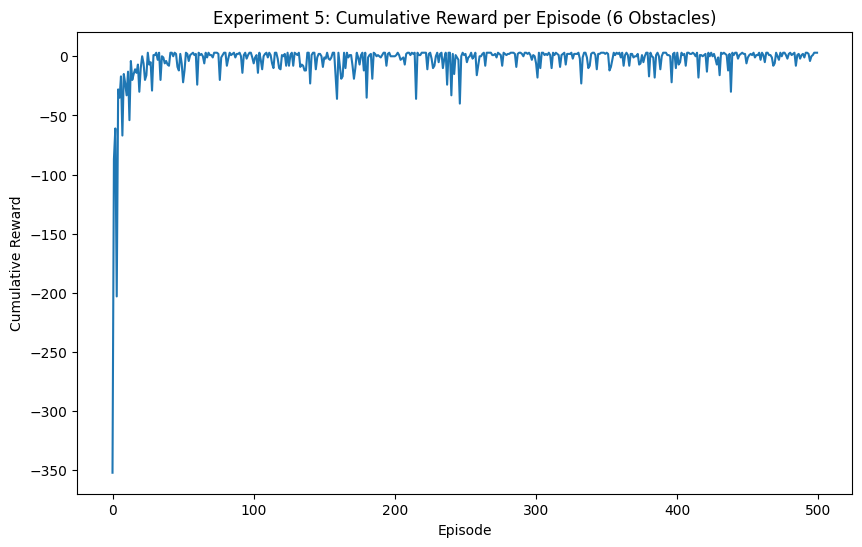

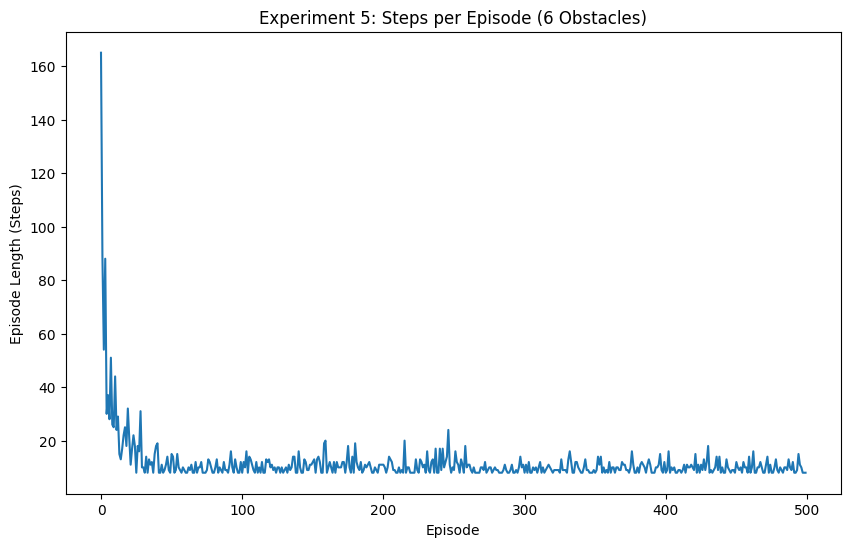

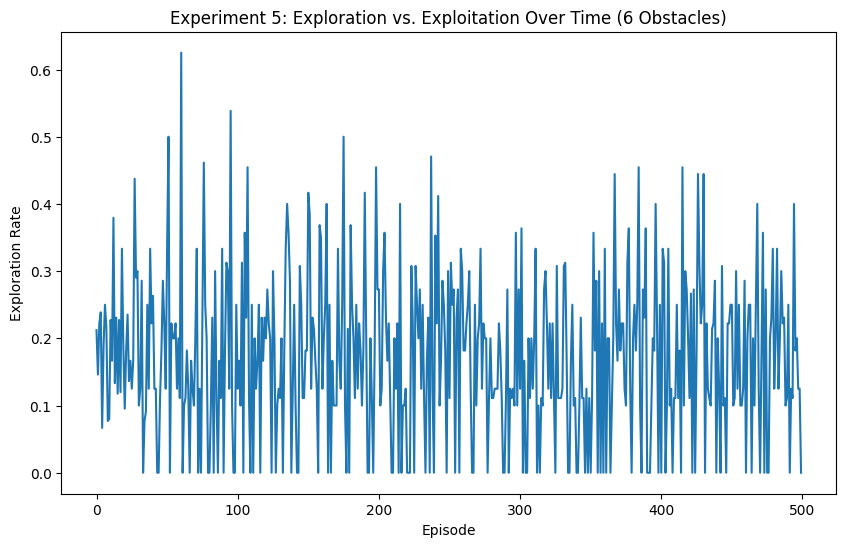

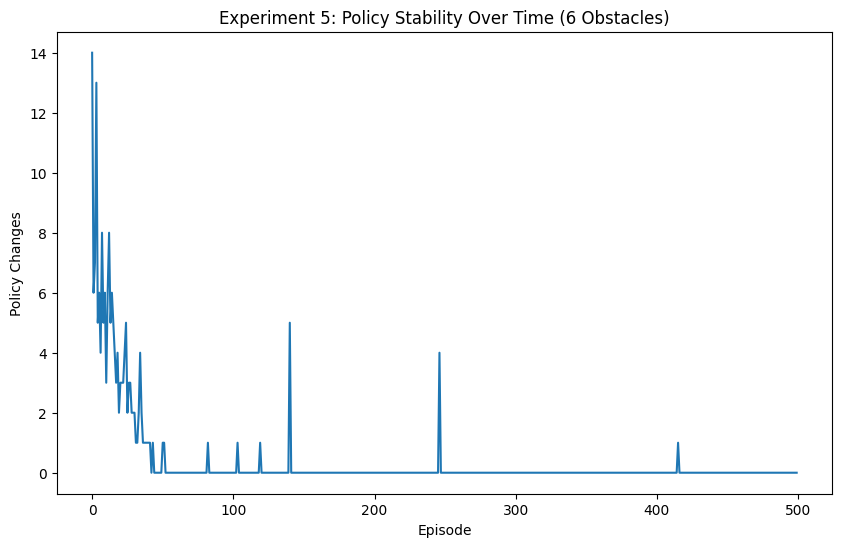

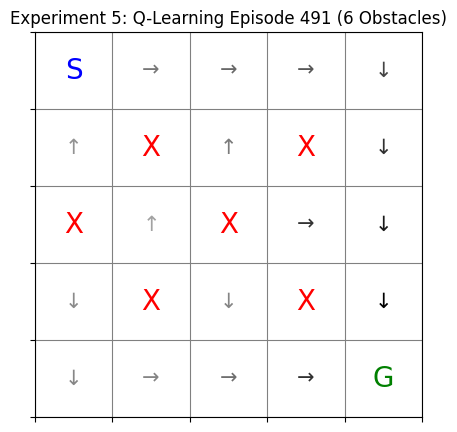

In [3]:
# Import required libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Set up environment parameters with MORE OBSTACLES
grid_size = 5
start = (0, 0)
goal = (4, 4)
obstacles = [(1, 1), (2, 2), (3, 3), (1, 3), (3, 1), (2, 0)]  # 6 obstacles

# Actions (Up, Down, Left, Right)
actions = {
    0: (-1, 0),  # Up
    1: (1, 0),   # Down
    2: (0, -1),  # Left
    3: (0, 1)    # Right
}

# Initialize Q-table
q_table_exp5 = np.zeros((grid_size, grid_size, len(actions)))

# Hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.9    # Discount factor
epsilon = 0.2  # Exploration factor
episodes = 500  # Number of episodes for training

# Metrics storage
cumulative_rewards_exp5 = []
episode_lengths_exp5 = []
exploration_counts_exp5 = []
policy_changes_exp5 = []
frames_exp5 = []  # Store frames for animation

# Reward function
def get_reward(state):
    if state == goal:
        return 10
    elif state in obstacles:
        return -10
    else:
        return -1

# Helper function to get new state
def get_next_state(state, action):
    next_state = (state[0] + action[0], state[1] + action[1])
    if 0 <= next_state[0] < grid_size and 0 <= next_state[1] < grid_size:
        return next_state
    else:
        return state  # Stay in the same place if move is out of bounds

# Training function for Q-Learning
def train_agent_exp5():
    for episode in range(episodes):
        state = start
        episode_reward = 0  # Track cumulative reward
        steps = 0           # Track episode length
        explore_count = 0
        exploit_count = 0
        policy_change_count = 0
        previous_policy = np.copy(q_table_exp5)  # Snapshot of policy at episode start

        while state != goal:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action_idx = random.choice(list(actions.keys()))
                explore_count += 1
            else:
                action_idx = np.argmax(q_table_exp5[state[0], state[1]])
                exploit_count += 1

            # Take action and observe reward
            action = actions[action_idx]
            next_state = get_next_state(state, action)
            reward = get_reward(next_state)

            # Update Q-value
            old_value = q_table_exp5[state[0], state[1], action_idx]
            next_max = np.max(q_table_exp5[next_state[0], next_state[1]])
            q_table_exp5[state[0], state[1], action_idx] = old_value + alpha * (reward + gamma * next_max - old_value)

            # Move to next state and accumulate metrics
            episode_reward += reward
            steps += 1
            state = next_state

        # Record policy changes
        for x in range(grid_size):
            for y in range(grid_size):
                if np.argmax(previous_policy[x, y]) != np.argmax(q_table_exp5[x, y]):
                    policy_change_count += 1

        # Store metrics after each episode
        cumulative_rewards_exp5.append(episode_reward)
        episode_lengths_exp5.append(steps)
        exploration_counts_exp5.append((explore_count, exploit_count))
        policy_changes_exp5.append(policy_change_count)

        # Capture frames every 10 episodes for the animation
        if episode % 10 == 0:
            frames_exp5.append((np.copy(q_table_exp5), episode + 1))

# Plotting function for all metrics
def plot_metrics_exp5():
    # Cumulative Rewards
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_rewards_exp5)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Experiment 5: Cumulative Reward per Episode (6 Obstacles)')
    plt.show()

    # Episode Length
    plt.figure(figsize=(10, 6))
    plt.plot(episode_lengths_exp5)
    plt.xlabel('Episode')
    plt.ylabel('Episode Length (Steps)')
    plt.title('Experiment 5: Steps per Episode (6 Obstacles)')
    plt.show()

    # Exploration vs Exploitation Ratio
    explore_ratios = [explore / (explore + exploit) for explore, exploit in exploration_counts_exp5]
    plt.figure(figsize=(10, 6))
    plt.plot(explore_ratios, label="Exploration Rate")
    plt.xlabel('Episode')
    plt.ylabel('Exploration Rate')
    plt.title('Experiment 5: Exploration vs. Exploitation Over Time (6 Obstacles)')
    plt.show()

    # Policy Stability
    plt.figure(figsize=(10, 6))
    plt.plot(policy_changes_exp5)
    plt.xlabel('Episode')
    plt.ylabel('Policy Changes')
    plt.title('Experiment 5: Policy Stability Over Time (6 Obstacles)')
    plt.show()

# Visualization of the learning process
def animate_learning_exp5():
    fig, ax = plt.subplots(figsize=(5, 5))

    def animate(i):
        ax.clear()
        q_table, episode = frames_exp5[i]
        ax.set_title(f"Experiment 5: Q-Learning Episode {episode} (6 Obstacles)")

        # Display the Q-values as arrows with color intensity
        for x in range(grid_size):
            for y in range(grid_size):
                max_action = np.argmax(q_table[x, y])
                max_q_value = np.max(q_table[x, y])
                intensity = (max_q_value - np.min(q_table)) / (np.max(q_table) - np.min(q_table) + 1e-6)
                color = (0, 0, 0, intensity)  # Darker color for higher Q-values

                if (x, y) == goal:
                    ax.text(y, x, 'G', ha='center', va='center', color='green', fontsize=20)
                elif (x, y) in obstacles:
                    ax.text(y, x, 'X', ha='center', va='center', color='red', fontsize=20)
                elif (x, y) == start:
                    ax.text(y, x, 'S', ha='center', va='center', color='blue', fontsize=20)
                else:
                    arrow = {0: '↑', 1: '↓', 2: '←', 3: '→'}[max_action]
                    ax.text(y, x, arrow, ha='center', va='center', color=color, fontsize=15)

        ax.set_xticks(np.arange(-0.5, grid_size, 1))
        ax.set_yticks(np.arange(-0.5, grid_size, 1))
        ax.grid(color='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.gca().invert_yaxis()

    # Create the animation and assign it to a variable to prevent garbage collection
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_exp5), interval=100)

    # Return the animation for inline display in Jupyter
    return HTML(anim.to_jshtml())

# Run the training, plot metrics, and show animation
train_agent_exp5()
plot_metrics_exp5()
animate_learning_exp5()  # Ensure the return value is displayed


### Observed Outcome

The cumulative reward plot shows significantly lower initial rewards compared to the 3-obstacle environment, with the agent experiencing more frequent penalties during early episodes. Total rewards took approximately 200 to 250 episodes to stabilize near zero, whereas the original setup converged around episode 150. The reward curve exhibits more volatility throughout training, indicating that the increased obstacle density forces the agent to explore longer before discovering safe paths. Episode lengths remained elevated for a longer period, showing that finding an efficient route through the crowded grid requires more trial-and-error learning.


### Conceptual Insight

Adding more obstacles reduces the number of valid paths to the goal, making the state space effectively more constrained and the reward landscape sparser. This forces the agent to encounter more negative rewards during exploration, which slows convergence as fewer actions lead to positive outcomes. The increased density of penalties also means that Q-value propagation from the goal state takes longer to reach distant states, as updates must navigate around multiple blocked cells. This experiment demonstrates how environmental complexity directly impacts sample efficiency in temporal difference learning.


### Reflection

With six obstacles blocking nearly a quarter of the grid, the agent must navigate a much narrower corridor to reach the goal, which requires more precise policy updates to avoid dead ends. Early episodes show erratic behavior as random exploration frequently leads to obstacle collisions, accumulating large negative rewards and extending episode lengths. However, once the agent discovers a viable path through temporal difference updates, the policy stabilizes around this route, though convergence takes 50 to 100 additional episodes compared to the baseline.


### Question 1: How does the agent's path change with additional obstacles?

The agent's learned path becomes more indirect and constrained, requiring more strategic turns to avoid the six blocked cells scattered throughout the grid. Instead of the relatively straight diagonal route seen with three obstacles, the final policy shows a winding trajectory that carefully navigates around multiple penalty zones. The increased obstacle density forces the agent to exploit specific safe corridors, resulting in a longer optimal path length with more directional changes. This adaptation is visible in the final policy grid, where arrows show deliberate detours around clustered obstacles rather than direct movement toward the goal.


### Question 2: Does it take longer for the agent to learn the optimal path in a more challenging grid?

Yes, the agent requires significantly more episodes to converge when facing six obstacles compared to three. The episode length plot shows that steps per episode remain high for approximately 100 to 150 episodes before declining, whereas the baseline environment showed rapid improvement by episode 60. Cumulative rewards also stabilize later, around episode 200 to 250 instead of episode 150, indicating delayed policy convergence. The extended learning period occurs because the agent must explore more extensively to discover viable paths through the crowded grid, and Q-value updates propagate more slowly through the constrained state space.
